In [1]:
import numpy as np
from numpy import linalg as LA
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
#Domain limits
ax=-np.pi
bx=np.pi
ay=-np.pi
by=np.pi

In [3]:
#Function to create mesh for simulations
def make_domain(n):
    x=np.linspace(ax,bx,n)
    y=np.linspace(ay,by,n)
    X,Y= np.meshgrid(x,y)
    u=np.zeros_like(X)
    delx=x[1]-x[0]
    return (x,y,X,Y,delx)

In [4]:
#Tridiagonal Solving parameters
#a = lower dia, b = main dia, c = upper dia, d = solution vector
def thomas(a,b,c,d):
    n = len(d)
    w= np.zeros(n-1,float)
    g= np.zeros(n, float)
    p = np.zeros(n,float)

    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p

In [5]:
#p-norm
def norm(u,p):
    return (np.average(np.abs(u**p)))**(1/p)

In [6]:
#Optimized function for explicit integration
def explicit(u,f,delt,delx):
    #Roll operation rolls the matrices in respective directions
    u_upd= u + delt*f + delt/delx**2*(np.roll(u,1,axis=0)+np.roll(u,-1,axis=0)\
                                     +np.roll(u,1,axis=1)+np.roll(u,-1,axis=1)-4*u)
    #Remove boundaries since roll operations contaminate the edges
    u[1:-1,1:-1]=u_upd[1:-1,1:-1]
    return u

In [7]:
#Unoptimized explicit integration that uses 2 for loops
def explicit_loop(u,f,delt):
    lam=delt/delx**2
    u_new= u + delt*f
    for row in range(1,len(y)-1):
        for col in range(1,len(x)-1):
            u_new[row,col]= u_new[row,col]+ lam*(u[row+1,col]+u[row-1,col]\
                                                 +u[row,col+1]+u[row,col-1]-4*u[row,col])
    return u_new

# Validation for explicit scheme using all Drichlet BC

I used method of manufactured solution for the problem $D_{t}-D_{xx}-D_{yy}=f$. The solution is $u=e^{(t/\tau)}*\sin{kx}*\sin{ky}$ and function is $f=e^{t/\tau}*\sin{kx}*\sin{ky}*(\frac{1}{\tau}+2k^2)$. The initial condition is $u(x,y,0)=\sin{kx}\sin{ky}$ and the boundary condition is zero Drichlet boundary condition.

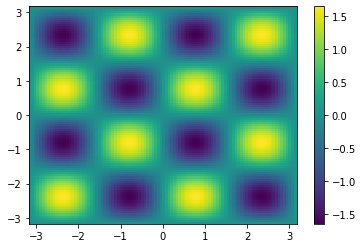

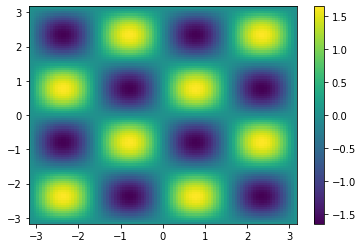

Norm 1 0.000826921153109709
Norm 2 0.0010306508332762199
Inf Norm 0.13119901109476914
Norm x=0 9.290990961235525e-05
Norm y=0 9.290990961232997e-05


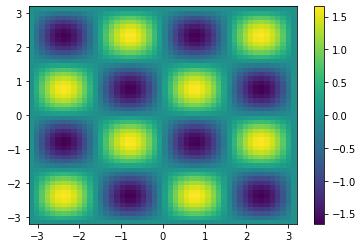

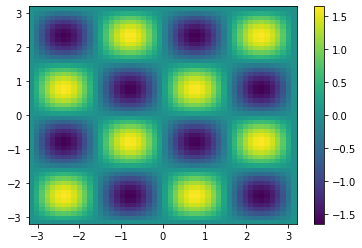

Norm 1 0.0033162841496477908
Norm 2 0.004177659366294597
Inf Norm 0.26573034668021134
Norm x=0 0.0007631817460664938
Norm y=0 0.0007631817460665043


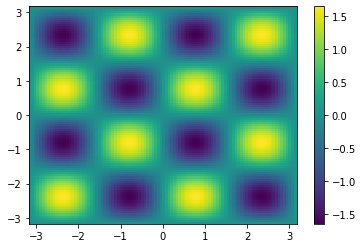

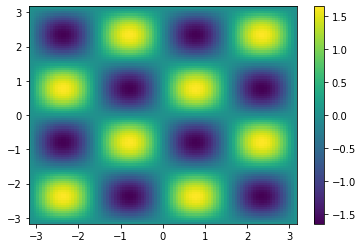

Norm 1 0.000826921153109709
Norm 2 0.0010306508332762199
Inf Norm 0.13119901109476914
Norm x=0 9.290990961235525e-05
Norm y=0 9.290990961232997e-05


0.0010306508332762199

In [24]:
def exp_dri(n,delt,total_t):
    
    #Make mesh
    x,y,X,Y,delx = make_domain(n)
    #delt=0.001
    #total_t=1

    #Equation variables and functions
    k=2
    tau=2

    def f(t):
        return np.exp(t/tau)*np.sin(k*X)*np.sin(k*Y)*(1/tau+2*k**2)
    
    #Definition to apply Boundary conditions
    def applyBC_man(u):
        u[0,:]=0
        u[-1,:]=0
        u[:,0]=0
        u[:,-1]=0
        return u

    #initial condition
    t=0
    u=np.sin(k*X)*np.sin(k*Y)
    
    #March in time
    while(np.abs(total_t-t)>1e-5):
        u=applyBC_man(u)
        u=explicit(u,f(t),delt,delx)
        t=t+delt
    
    #Evaluate analytical solution
    u_man_an=np.exp(t/tau)*np.sin(k*X)*np.sin(k*Y)
    
    #Plot numerical solution
    plt.pcolor(X,Y,u)
    plt.colorbar()
    plt.show()
    
    #Plot numerical solution
    plt.pcolor(X,Y,u_man_an)
    plt.colorbar()
    plt.show()
    
    #Printing all the norms
    print('Norm 1',norm(u-u_man_an,1))
    print('Norm 2',norm(u-u_man_an,2))
    print('Inf Norm',LA.norm(u-u_man_an,np.inf))
    print('Norm x=0',norm(u[:,int(len(x)/2)]-u_man_an[:,int(len(x)/2)],2))
    print('Norm y=0',norm(u[int(len(x)/2),:]-u_man_an[int(len(x)/2),:],2))
    
    #Outputs norm for validation
    return norm(u-u_man_an,2)

(np.log(exp_dri(100,0.0001,1))-np.log(exp_dri(50,0.0001,1)))/np.log(2)
exp_dri(100,0.0001,1)

# Validation for explicit scheme using one Neumann BC (Without ghost cells)

I used the same manufactured solution, except I used one Neumann BC at $u(x=bx)=-e^{t/\tau}\sin(ky)$

In [9]:
def exp_new(n,delt,total_t):
    
    #Make mesh
    #n=80
    x,y,X,Y,delx = make_domain(n)
    #delt=0.001
    #total_t=0.01

    #Equation variables and functions
    k=1
    tau=2
    def f(t):
        return np.exp(t/tau)*np.sin(k*X)*np.sin(k*Y)*(1/tau+2*k**2)
    
    #Apply Boundary Conditions
    def applyBC_man_New(u,t):
        u[0,:]=0
        u[-1,:]=0
        u[:,0]= 0
        #The following BC reduces the spatial accuracy from order 2 to 1
        u[:,-1]= u[:,-2]+delx*k*np.exp(t/tau)*np.sin(k*Y[:,-1])*np.cos(k*X[:,-1])
        return u

    #Apply initial condition
    u=np.sin(k*X)*np.sin(k*Y)
    t=0
    
    #March in time
    while(np.abs(total_t-t)>1e-5):
        u=applyBC_man_New(u,t)
        u=explicit(u,f(t),delt,delx)
        t=t+delt
    
    #Evaluate analytical solution
    u_man_an=np.exp(t/tau)*np.sin(k*X)*np.sin(k*Y)
    
    #Plot numerical solution        
    plt.pcolor(X,Y,u)
    plt.colorbar()
    plt.show()

    #Plot Analytical solution
    plt.pcolor(X,Y,u_man_an)
    plt.colorbar()
    plt.show()
    
    #Print norms
    print('Norm 1',norm(u-u_man_an,1))
    print('Norm 2',norm(u-u_man_an,2))
    print('Inf Norm',LA.norm(u-u_man_an,np.inf))
    print('Norm x=0',norm(u[:,int(len(x)/2)]-u_man_an[:,int(len(x)/2)],2))
    print('Norm y=0',norm(u[int(len(x)/2),:]-u_man_an[int(len(x)/2),:],2))
    
    #Returns norm for validation
    return norm(u-u_man_an,2)

#(np.log(exp_new(100,0.0001,1))-np.log(exp_new(50,0.0001,1)))/np.log(2)
#exp_new(100,0.0001,1)

# Validation for explicit scheme using one Neumann BC (With ghost cells)

In [10]:
def exp_new_gh(n,delt,total_t):
    
    #Make mesh
    #n=10
    x,y,X,Y,delx = make_domain(n)
    #delt=0.0001
    #total_t=10

    #Equation variables and functions
    k=1
    tau=2
    def f_gh(t):
        return np.column_stack((np.exp(t/tau)*np.sin(k*X)*np.sin(k*Y)*(1/tau+2*k**2),\
                               np.zeros_like(y)))
    
    #Apply boundary conditions
    def applyBC_man_New_gh(u,t):
        u[0,:]=0
        u[-1,:]=0
        u[:,0]= 0
        #The following BC is 2nd order
        u[:,-1]= u[:,-3]+2*delx*k*np.exp(t/tau)*np.sin(k*Y[:,-1])*np.cos(k*X[:,-1])
        return u

    #initial condition
    u=np.sin(k*X)*np.sin(k*Y)
    #Add ghost cells
    u=np.column_stack((u,np.zeros_like(y)))
    t=0
    
    #March in time
    while(np.abs(total_t-t)>1e-5):
        u=applyBC_man_New_gh(u,t)
        u=explicit(u,f_gh(t),delt,delx)
        t=t+delt
    
    #Remove ghost cells
    u= u[:,:-1]
    
    #Find analytical solution
    u_man_an=np.exp(t/tau)*np.sin(k*X)*np.sin(k*Y)

    #Plot numerical solution
    plt.pcolor(X,Y,u)
    plt.colorbar()
    plt.show()
    
    #Plot analytical solution
    plt.pcolor(X,Y,u_man_an)
    plt.colorbar()
    plt.show()

    #Print norms
    print('Norm 1',norm(u-u_man_an,1))
    print('NOrm 2',norm(u-u_man_an,2))
    print('Inf Norm',LA.norm(u-u_man_an,np.inf))
    print('Norm x=0',norm(u[:,int(len(x)/2)]-u_man_an[:,int(len(x)/2)],2))
    print('Norm y=0',norm(u[int(len(x)/2),:]-u_man_an[int(len(x)/2),:],2))
    
    #return norm for validation
    return norm(u-u_man_an,2)

#(np.log(exp_new_gh(100,0.0001,1))-np.log(exp_new_gh(50,0.0001,1)))/np.log(2)
#3exp_new_gh(100,0.0001,1)

In [11]:
#function to explicitly integrate in x direction
def explicit_x(u,f,delt,delx):
    u_upd= u + delt*f + delt/delx**2*(np.roll(u,1,axis=1)+np.roll(u,-1,axis=1)-2*u)
    u[:,1:-1]=u_upd[:,1:-1]
    return u

#function to explicitly integrate in y direction
def explicit_y(u,f,delt,delx):
    u_upd= u + delt*f + delt/delx**2*(np.roll(u,1,axis=0)+np.roll(u,-1,axis=0)-2*u)
    u[1:-1,:]=u_upd[1:-1,:]
    return u

# Validation for implicit scheme using Drichlet BC

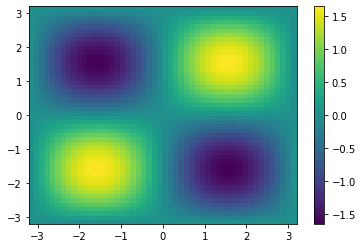

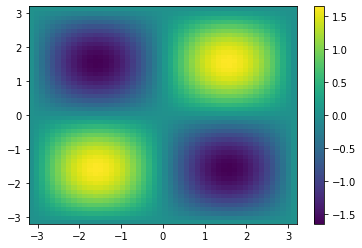

Norm 1 0.0005718199295760408
Norm 2 0.0007203450539307109
Inf Norm 0.04581932707458898
Norm x=0 6.593238009630163e-05
Norm y=0 6.593238009630139e-05


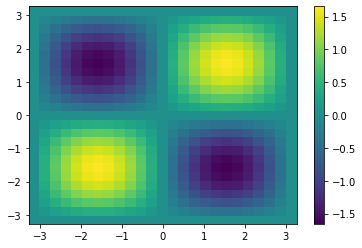

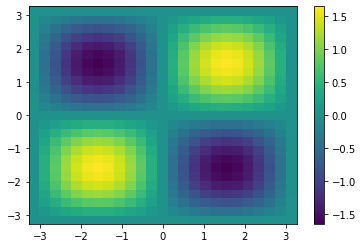

Norm 1 0.002486509525716304
Norm 2 0.0032322846205649633
Inf Norm 0.10229849666733322
Norm x=0 3.857055559840714e-16
Norm y=0 2.2888967324018076e-16


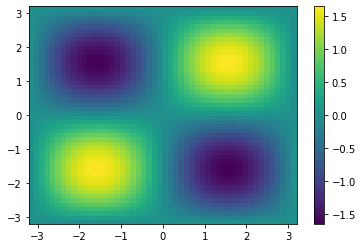

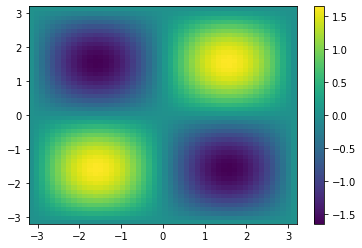

Norm 1 0.0005718199295760408
Norm 2 0.0007203450539307109
Inf Norm 0.04581932707458898
Norm x=0 6.593238009630163e-05
Norm y=0 6.593238009630139e-05


0.0007203450539307109

In [28]:
def adi_dri(n,delt,total_t):

    #n=20
    x,y,X,Y,delx = make_domain(n)
    #delt=0.001
    #total_t=0.1
    lam_h=delt/(2*delx**2)

    #Equation variables and functions
    k=1
    tau=2
    def f(t):
        return np.exp(t/tau)*np.sin(k*X)*np.sin(k*Y)*(1/tau+2*k**2)

    #Boundary conditions
    def ux0(t):
        return np.zeros_like(y)
    def uxl(t):
        return np.zeros_like(y)
    def uy0(t):
        return np.zeros_like(x)
    def uyl(t):
        return np.zeros_like(x)


    #Functions to apply boundary condition in explicit part:
    def applyBC_y0yl_ex(u,t):
        u[0,:]=uy0(t)
        u[-1,:]=uyl(t)
        return u
    def applyBC_x0xl_ex(u,t):
        u[:,0]= ux0(t)
        u[:,-1]=uxl(t)
        return u
    
    #Functions to apply boundary condition in implicit part
    def applyBC_x0xl_imp(t,delx):
        return ux0(t),uxl(t)
    def applyBC_y0yl_imp(t,delx):
        return uy0(t),uyl(t)
    
    #Initialize solution
    u=np.sin(k*X)*np.sin(k*Y)
    t=0
    
    #March in time
    while(np.abs(total_t-t)>1e-5):
        
        #Adding BCs in y=0 and y=L
        u=applyBC_y0yl_ex(u,t)
        
        #Explicit in y direction
        exp_y=explicit_y(u,f(t),delt/2,delx)
        t=t+delt/2
        
        #Preparing vectors for implicit scheme
        a=-lam_h*np.ones(n-2)
        b=(1+2*lam_h)*np.ones(n-2)
        c=-lam_h*np.ones(n-2)
        
        #Adding BCs in x=0 and x=L
        [x0,xl]=applyBC_x0xl_imp(t,delx)
        exp_y[:,1]=exp_y[:,1]+lam_h*x0[:]
        exp_y[:,-2]=exp_y[:,-2]+lam_h*xl[:]
        
        #Implicit in x direction
        for coli in range(n): #Cover all rows
            u[coli,1:-1]=thomas(a,b,c,exp_y[coli,1:-1])

        
        #Adding BCs in x=0, x=L
        u=applyBC_x0xl_ex(u,t)
        exp_x=explicit_x(u,f(t),delt/2,delx)
        t=t+delt/2
        
        #Preparing vectors for implicit scheme
        a=-lam_h*np.ones(n-2)
        b=(1+2*lam_h)*np.ones(n-2)
        c=-lam_h*np.ones(n-2)
        
        #Adding BCs in y=0 and y=L
        [y0,yl]=applyBC_y0yl_imp(t,delx)
        exp_x[1,:]=exp_x[1,:]+lam_h*y0[:]
        exp_x[-2,:]=exp_x[-2,:]+lam_h*yl[:]
        
        #Implicit in y direction
        for rowi in range(n): #Cover all columns
            u[1:-1,rowi]=thomas(a,b,c,exp_x[1:-1,rowi])

        #Calcuate analytical solution
        u_man_an=np.exp(t/tau)*np.sin(k*X)*np.sin(k*Y)

    plt.pcolor(X,Y,u)
    plt.colorbar()
    plt.show()

    plt.pcolor(X,Y,u_man_an)
    plt.colorbar()
    plt.show()

    #Print Norms
    print('Norm 1',norm(u-u_man_an,1))
    print('Norm 2',norm(u-u_man_an,2))
    print('Inf Norm',LA.norm(u-u_man_an,np.inf))
    print('Norm x=0',norm(u[:,int(len(x)/2)]-u_man_an[:,int(len(x)/2)],2))
    print('Norm y=0',norm(u[int(len(x)/2),:]-u_man_an[int(len(x)/2),:],2))
    
    #return norm for validation
    return norm(u-u_man_an,2)

(np.log(adi_dri(50,0.001,1))-np.log(adi_dri(25,0.001,1)))/np.log(2)
adi_dri(50,0.001,1)

# Validation for implicit scheme using Drichlet and Neumann BC

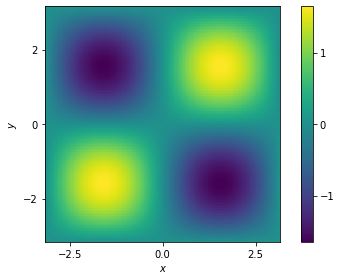

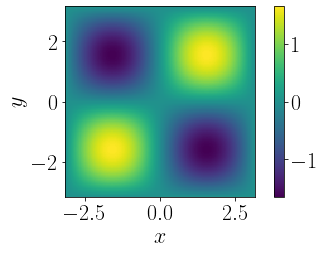

Norm 1 3.094913753984e-05
NOrm 2 6.584789229556362e-05
Inf Norm 0.0073892321755265776
Norm x=0 1.3626514341654083e-06
Norm y=0 5.201060002046408e-17


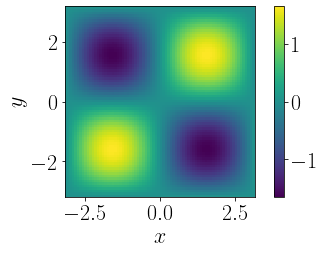

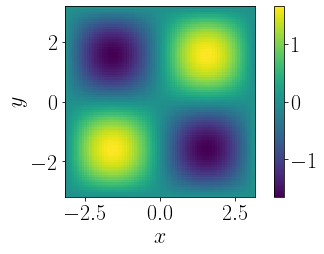

Norm 1 0.0002085576788601165
NOrm 2 0.0002722241516362815
Inf Norm 0.025227849527957674
Norm x=0 1.0057214577781666e-05
Norm y=0 1.6228538691477514e-05


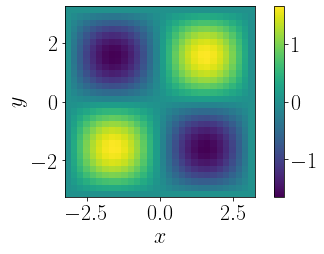

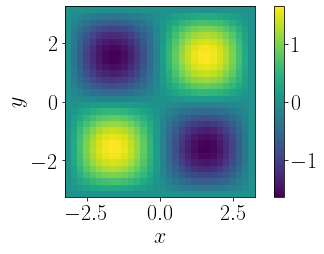

Norm 1 0.0017127568064153709
NOrm 2 0.002210728125946588
Inf Norm 0.0834541057544327
Norm x=0 0.0003035955814329255
Norm y=0 0.00034380647930817875


0.002210728125946588

In [29]:
def adi_new(n,delt,total_t):

    #n=160
    x,y,X,Y,delx = make_domain(n)
    #delt=0.001
    #total_t=0.1
    lam_h=delt/(2*delx**2)

    #Equation variables
    k=1
    tau=2
    def f(t):
        return np.exp(t/tau)*np.sin(k*X)*np.sin(k*Y)*(1/tau+2*k**2)
    
    #RHS function with ghost cells
    def f_gh(t):
        return np.column_stack((np.exp(t/tau)*np.sin(k*X)*np.sin(k*Y)*(1/tau+2*k**2),\
                               np.zeros_like(y)))
    
    #Boundary conditions
    def ux0(t):
        return np.zeros_like(y)
    def duxl(t):
        return k*np.exp(t/tau)*np.sin(k*Y[:,-1])*np.cos(k*X[:,-1])
    def uy0(t):
        return np.zeros_like(x)
    def uyl(t):
        return np.zeros_like(x)

    #Functions to apply boundary condition in explicit part:
    def applyBC_y0yl_ex(u,t):
        u[0,:]=uy0(t)
        u[-1,:]=uyl(t)
        return u
    def applyBC_x0xl_ex(u,t):
        u[:,0]= ux0(t)
        u[:,-1]= u[:,-3]+2*delx*duxl(t)
        return u
    
    #Functions to apply boundary condition in implicit part:
    def applyBC_x0xl_imp(t):
        return ux0(t),2*delx*duxl(t)
    def applyBC_y0yl_imp(t):
        return uy0(t),uyl(t)

    #Initialize solution
    u=np.sin(k*X)*np.sin(k*Y)
    t=0

    #March in time
    while(np.abs(total_t-t)>1e-5):
        
        #Adding BCs in y=0 and y=L
        u=applyBC_y0yl_ex(u,t)
        
        #Explicit in y direction
        exp_y=explicit_y(u,f(t),delt/2,delx)
        t=t+delt/2
        
        #Preparing vectors for implicit scheme
        a=-lam_h*np.ones(n-1)
        b=(1+2*lam_h)*np.ones(n-1)
        c=-lam_h*np.ones(n-1)
        
        #Adding BCs in x=0 and x=L
        [x0,xl]=applyBC_x0xl_imp(t)
        a[-2]=a[-2]-lam_h
        exp_y[:,1]=exp_y[:,1]+lam_h*x0[:]
        exp_y[:,-1]=exp_y[:,-1]+lam_h*xl[:]
        
        #Implicit in x direction
        for coli in range(n): #Cover all rows
            u[coli,1:]=thomas(a,b,c,exp_y[coli,1:])

        #Add ghost cells
        u=np.column_stack((u,np.zeros_like(y)))
        
        #Adding BCs in x=0 and x=L
        u=applyBC_x0xl_ex(u,t)
        exp_x=explicit_x(u,f_gh(t),delt/2,delx)
        
        #Remove ghost cells
        u=u[:,:-1]
        exp_x=exp_x[:,:-1]
        
        #Explicit in x direction
        t=t+delt/2
        a=-lam_h*np.ones(n-2)
        b=(1+2*lam_h)*np.ones(n-2)
        c=-lam_h*np.ones(n-2)
        
        #Adding BCs in y=0 and y=L
        [y0,yl]=applyBC_y0yl_imp(t)
        exp_x[1,:]=exp_x[1,:]+lam_h*y0[:]
        exp_x[-2,:]=exp_x[-2,:]+lam_h*yl[:]
    
        #Implicit in y direction
        for j in range(n): #Cover all columns
            u[1:-1,j]=thomas(a,b,c,exp_x[1:-1,j])

    #Calculate analytical solution
    u_man_an=np.exp(t/tau)*np.sin(k*X)*np.sin(k*Y)
    
    #Plot numerical solution
    plt.pcolor(X,Y,u)
    plt.colorbar()
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.axis('equal')
    plt.gca().set_aspect('equal',adjustable='box')
    plt.gcf().tight_layout()
    plt.rc('text', usetex=True)
    plt.rc('font', size=22)
    plt.savefig('adi_num.pdf')
    plt.show()
    
    #Plot analytical solution
    plt.pcolor(X,Y,u_man_an)
    plt.colorbar()
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.axis('equal')
    plt.gca().set_aspect('equal',adjustable='box')
    plt.gcf().tight_layout()
    plt.rc('text', usetex=True)
    plt.rc('font', size=22)
    plt.savefig('adi_an.pdf')
    plt.show()

    #Print norms
    print('Norm 1',norm(u-u_man_an,1))
    print('NOrm 2',norm(u-u_man_an,2))
    print('Inf Norm',LA.norm(u-u_man_an,np.inf))
    print('Norm x=0',norm(u[:,int(len(x)/2)]-u_man_an[:,int(len(x)/2)],2))
    print('Norm y=0',norm(u[int(len(x)/2),:]-u_man_an[int(len(x)/2),:],2))
    
    #Return norm for validation
    return norm(u-u_man_an,2)

(np.log(adi_new(151,0.001,1))-np.log(adi_new(76,0.001,1)))/np.log(2)
adi_new(30,0.001,1)

# Given Project: B2-1

In [14]:
#Functions used in given problem
def gb(x):
    return (bx-x)**2*np.cos(np.pi*x/bx)

def fb(x):
    return x*(bx-x)**2

# Explicit scheme for project 

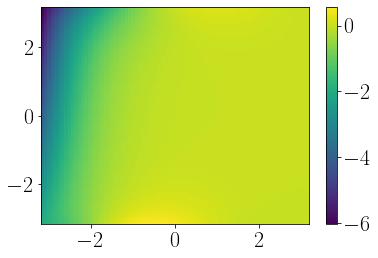

array([[-1.92519738e+00, -1.87083392e+00, -1.80586303e+00, ...,
        -1.21832554e-03, -3.07500644e-04, -0.00000000e+00],
       [-1.97738711e+00, -1.88910386e+00, -1.80205426e+00, ...,
        -2.32520993e-03, -1.60894188e-03, -1.36684650e-03],
       [-2.02957684e+00, -1.91754625e+00, -1.81165532e+00, ...,
        -3.00168198e-03, -2.44576582e-03, -2.25759975e-03],
       ...,
       [-5.94380649e+00, -5.58107027e+00, -5.24581817e+00, ...,
         1.26911212e-02,  1.07866782e-02,  1.01442333e-02],
       [-5.99599622e+00, -5.65805850e+00, -5.34250634e+00, ...,
         8.85647711e-03,  6.58781395e-03,  5.81763170e-03],
       [-6.04818595e+00, -5.74676968e+00, -5.45489725e+00, ...,
         3.68014657e-03,  9.44570953e-04,  0.00000000e+00]])

In [31]:
def exp_proj(lam,n,delt,total_t):
    
    #Make mesh
    #n=10
    x,y,X,Y,delx = make_domain(n)
    #delt=0.0001
    #total_t=10
    
    #Functions and definitions used 
    #lam=0.05
    
    #Function in the RHS: Zero for the given case
    def f_gh(t):
        return 0
    
    #Apply Boundary condition with ghost nodes
    def applyBC_man_New_gh(u,t):
        u[0,:]=np.append((1-np.exp(-lam*t))*gb(X[0,:]),0) #y= bot
        u[-1,:]=np.append((1-np.exp(-lam*t))*fb(X[-1,:]),0) #y=top
        u[:,0]= (1-np.exp(-lam*t))*(gb(ax)+(Y[:,0]-ay)/(by-ay)*(fb(ax)-gb(ax))) #x=bot
        #The following BC is 2nd order
        u[:,-1]= u[:,-3]+2*delx*0 #x=top
        return u 

    #Initialize solution
    u=np.zeros_like(X)
    #Insert ghost cells
    u=np.column_stack((u,np.zeros_like(y)))
    t=0
    
    #March in time
    while(np.abs(total_t-t)>1e-5):
        u=applyBC_man_New_gh(u,t)
        u=explicit(u,f_gh(t),delt,delx)
        t=t+delt

    u= u[:,:-1]
    
    #Plot numerical solution
    plt.pcolor(X,Y,u)
    plt.colorbar()
    plt.show()
    
    #return solution matrix
    return u

exp_proj(0.05,80,0.0001,1)


# ADI scheme for the project

In [16]:
def adi_proj(lam,n,delt,total_t):
    
    #Make mesh
    #lam=0.05
    #n=160
    x,y,X,Y,delx = make_domain(n)
    #delt=0.001
    #total_t=0.1
    lam_h=delt/(2*delx**2)

    #Boundary Conditions
    def ux0(t):
        return (1-np.exp(-lam*t))*(gb(ax)+(Y[:,0]-ay)/(by-ay)*(fb(ax)-gb(ax)))
    def duxl(t):
        return np.zeros_like(Y[:,-1])
    def uy0(t):
        return (1-np.exp(-lam*t))*gb(X[0,:])
    def uyl(t):
        return (1-np.exp(-lam*t))*fb(X[-1,:])

    #Function in the RHS. Zero in this case
    def f(t):
        return 0
    #RhS function with ghost cells. Again zero in this case
    def f_gh(t):
        return 0

    #Functions to apply boundary conditions in explicit portion
    def applyBC_y0yl_ex(u,t):
        u[0,:]=uy0(t)
        u[-1,:]=uyl(t)
        return u
    def applyBC_x0xl_ex(u,t):
        u[:,0]= ux0(t)
        u[:,-1]= u[:,-3]+2*delx*duxl(t)
        return u
    
    #Functions to apply boundary conditions in implicit portion
    def applyBC_x0xl_imp(t):
        return ux0(t),2*delx*duxl(t)
    def applyBC_y0yl_imp(t):
        return uy0(t),uyl(t)

    #Initialize solution
    u=np.zeros_like(X)
    t=0

    #March in time
    while(np.abs(total_t-t)>1e-5):
        
        #Adding BCs in y=0 and y=L
        u=applyBC_y0yl_ex(u,t)
        
        #Explicit in y direction
        exp_y=explicit_y(u,f(t),delt/2,delx)
        t=t+delt/2
        
        #Preparing vectors for implicit scheme
        a=-lam_h*np.ones(n-1)
        b=(1+2*lam_h)*np.ones(n-1)
        c=-lam_h*np.ones(n-1)
        
        #Adding BCs in x=0 and x=L
        [x0,xl]=applyBC_x0xl_imp(t)
        a[-2]=a[-2]-lam_h
        exp_y[:,1]=exp_y[:,1]+lam_h*x0[:]
        exp_y[:,-1]=exp_y[:,-1]+lam_h*xl[:]
        
        #Implicit in x direction
        for coli in range(n): #Cover all rows
            u[coli,1:]=thomas(a,b,c,exp_y[coli,1:])

        #Add ghost cells
        u=np.column_stack((u,np.zeros_like(y)))
        
        #Adding BCs in x=0 and x=L
        u=applyBC_x0xl_ex(u,t)
        exp_x=explicit_x(u,f_gh(t),delt/2,delx)
        
        #Remove ghost cells
        u=u[:,:-1]
        exp_x=exp_x[:,:-1]
        
        #Explicit in x direction
        t=t+delt/2
        a=-lam_h*np.ones(n-2)
        b=(1+2*lam_h)*np.ones(n-2)
        c=-lam_h*np.ones(n-2)
        
        #Adding BCs in y=0 and y=L
        [y0,yl]=applyBC_y0yl_imp(t)
        exp_x[1,:]=exp_x[1,:]+lam_h*y0[:]
        exp_x[-2,:]=exp_x[-2,:]+lam_h*yl[:]

        #Implicit in y direction
        for j in range(n): #Cover all columns
            u[1:-1,j]=thomas(a,b,c,exp_x[1:-1,j])

    #Plot numerical solution
    plt.pcolor(X,Y,u)
    plt.colorbar()
    plt.show()
    
    #return solution for analysis
    return u

#adi_proj(0.05,30,0.01,1)

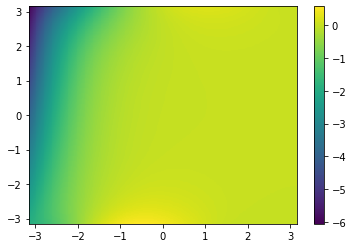

In [17]:
U_f_ex=exp_proj(0.05,301,0.00001,1)

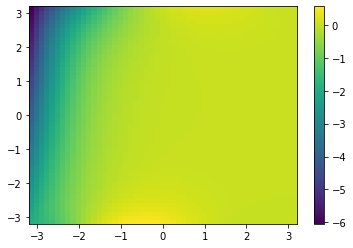

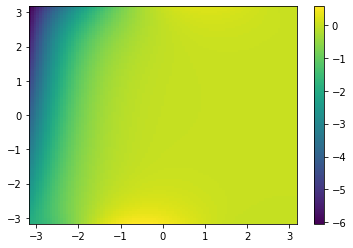

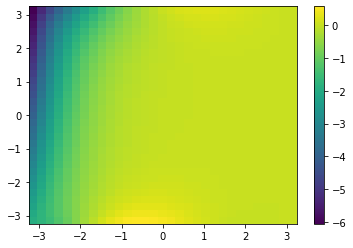

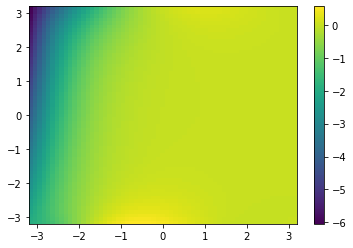

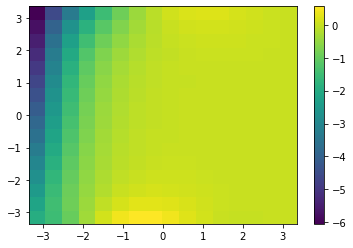

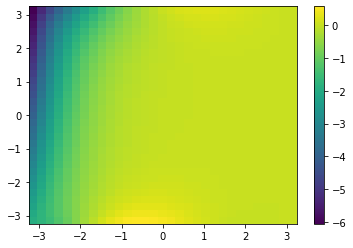

In [18]:
n=np.array([51,31,16])
askip=np.array([6,10,20])
n2=np.array([101,61,31])
askip2=np.array([3,5,10])
anorm=np.array([])
anorm2=np.array([])
for i in range(len(n)):
    anorm=np.append(anorm, norm(U_f_ex[::askip[i],::askip[i]]-adi_proj(0.05,n[i],0.001,1),2))
    anorm2= np.append(anorm2, norm(U_f_ex[::askip2[i],::askip2[i]]-adi_proj(0.05,n2[i],0.001,1),2))
order=(np.log(anorm)-np.log(anorm2))/(np.log(2))


In [19]:
print(anorm)
print(anorm2)
print(order)

[0.00072488 0.00180511 0.00671318]
[0.00029621 0.00054483 0.00180511]
[1.29113205 1.72819721 1.89491033]


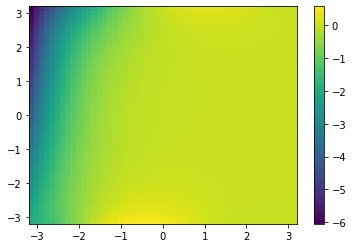

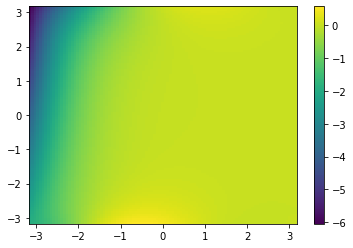

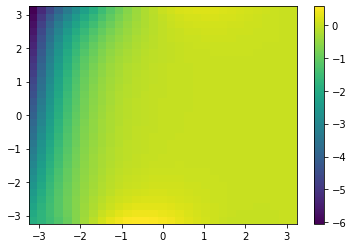

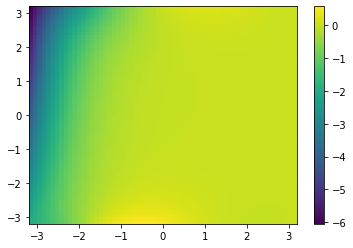

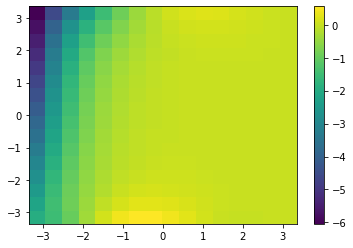

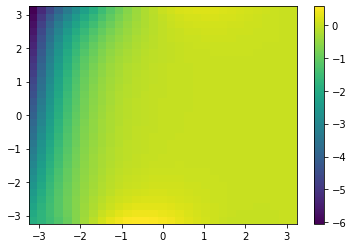

[0.00095663 0.00197032 0.00679628]
[0.00053619 0.0007903  0.00197032]
[0.8352005  1.31795446 1.78631278]


In [20]:
n=np.array([51,31,16])
askip=np.array([6,10,20])
n2=np.array([101,61,31])
askip2=np.array([3,5,10])
anorm=np.array([])
anorm2=np.array([])
for i in range(len(n)):
    anorm=np.append(anorm, norm(U_f_ex[::askip[i],::askip[i]]-adi_proj(0.05,n[i],0.002,1),2))
    anorm2= np.append(anorm2, norm(U_f_ex[::askip2[i],::askip2[i]]-adi_proj(0.05,n2[i],0.002,1),2))
order=(np.log(anorm)-np.log(anorm2))/(np.log(2))
print(anorm)
print(anorm2)
print(order)

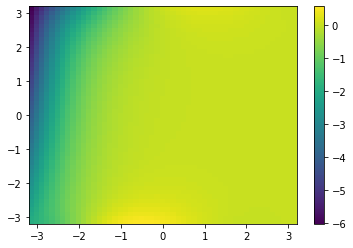

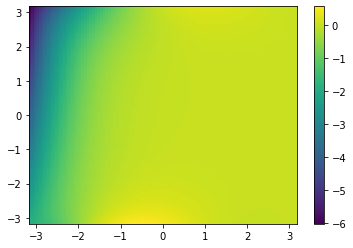

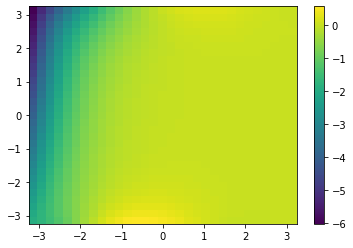

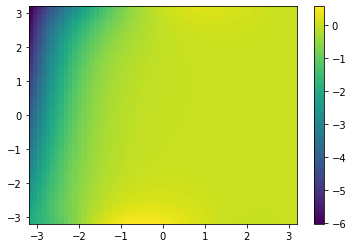

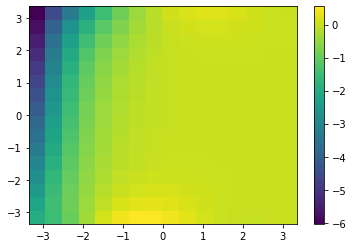

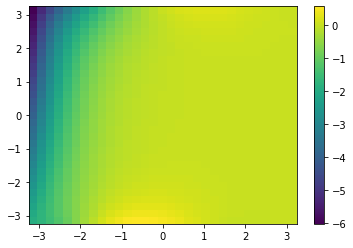

[0.00190041 0.00286758 0.00735201]
[0.00128905 0.0016994  0.00286758]
[0.56000014 0.75480615 1.35830484]


In [21]:
n=np.array([51,31,16])
askip=np.array([6,10,20])
n2=np.array([101,61,31])
askip2=np.array([3,5,10])
anorm=np.array([])
anorm2=np.array([])
for i in range(len(n)):
    anorm=np.append(anorm, norm(U_f_ex[::askip[i],::askip[i]]-adi_proj(0.05,n[i],0.005,1),2))
    anorm2= np.append(anorm2, norm(U_f_ex[::askip2[i],::askip2[i]]-adi_proj(0.05,n2[i],0.005,1),2))
order=(np.log(anorm)-np.log(anorm2))/(np.log(2))
print(anorm)
print(anorm2)
print(order)

# Steady state solution using ADI

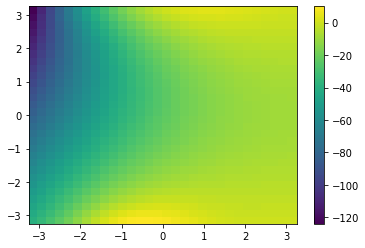

In [25]:
def adi_proj_steady(lam,n,delt,total_t):
    
    #Make mesh
    #n=160
    x,y,X,Y,delx = make_domain(n)
    #delt=0.001
    #total_t=0.1
    lam_h=delt/(2*delx**2)
   
    #lam=0.05
    def f(t):
        return 0

    def f_gh(t):
        return 0    
    
    #Boundary conditions
    def ux0(t):
        return (1-np.exp(-lam*t))*(gb(ax)+(Y[:,0]-ay)/(by-ay)*(fb(ax)-gb(ax)))
    def duxl(t):
        return np.zeros_like(Y[:,-1])
    def uy0(t):
        return (1-np.exp(-lam*t))*gb(X[0,:])
    def uyl(t):
        return (1-np.exp(-lam*t))*fb(X[-1,:])

    #Functions to apply boundary condition in explicit part:
    def applyBC_y0yl_ex(u,t):
        u[0,:]=uy0(t)
        u[-1,:]=uyl(t)
        return u
    def applyBC_x0xl_ex(u,t):
        u[:,0]= ux0(t)
        u[:,-1]= u[:,-3]+2*delx*duxl(t)
        return u
    
    #Functions to apply boundary condition in implicit part:
    def applyBC_x0xl_imp(t):
        return ux0(t),2*delx*duxl(t)
    def applyBC_y0yl_imp(t):
        return uy0(t),uyl(t)

    #Initialize solution
    u=np.zeros_like(X)
    t=0
    
    #Vector to check convergence to steady state
    u_ave=np.array([])
    u_ave=np.append(u_ave,np.average(np.abs(u)))
    
    #March in time
    while(np.abs(total_t-t)>1e-5):
        
        #Adding BCs in y=0 and y=L
        u=applyBC_y0yl_ex(u,t)
        
        #Explicit in y direction
        exp_y=explicit_y(u,f(t),delt/2,delx)
        t=t+delt/2
        
        #Preparing vectors for implicit scheme
        a=-lam_h*np.ones(n-1)
        b=(1+2*lam_h)*np.ones(n-1)
        c=-lam_h*np.ones(n-1)
        
        #Adding BCs in x=0 and x=L
        [x0,xl]=applyBC_x0xl_imp(t)
        a[-2]=a[-2]-lam_h
        exp_y[:,1]=exp_y[:,1]+lam_h*x0[:]
        exp_y[:,-1]=exp_y[:,-1]+lam_h*xl[:]
        
        #Implicit in x direction
        for coli in range(n): #Cover all rows
            u[coli,1:]=thomas(a,b,c,exp_y[coli,1:])
    
        #Add ghost cells
        u=np.column_stack((u,np.zeros_like(y)))
        
        #Adding BCs in x=0 and x=L
        u=applyBC_x0xl_ex(u,t)
        exp_x=explicit_x(u,f_gh(t),delt/2,delx)
        
        #Remove ghost cells
        u=u[:,:-1]
        exp_x=exp_x[:,:-1]
        
        #Explicit in x direction
        t=t+delt/2
        a=-lam_h*np.ones(n-2)
        b=(1+2*lam_h)*np.ones(n-2)
        c=-lam_h*np.ones(n-2)
        
        #Adding BCs in y=0 and y=L
        [y0,yl]=applyBC_y0yl_imp(t)
        exp_x[1,:]=exp_x[1,:]+lam_h*y0[:]
        exp_x[-2,:]=exp_x[-2,:]+lam_h*yl[:]

        #Implicit in y direction
        for j in range(n): #Cover all columns
            u[1:-1,j]=thomas(a,b,c,exp_x[1:-1,j])
            
        u_ave=np.append(u_ave,np.average(np.abs(u)))
        
        #Break loop once the required convergence is reached
        if (np.abs(u_ave[-2]-u_ave[-1])<1e-5):
            break
        #print('t=',t,'Norm 1=',np.abs(u_ave[-2]-u_ave[-1])) 
     
    #Plot numerical solution
    plt.pcolor(X,Y,u)
    plt.colorbar()
    plt.show()

    #return solution matrix
    return #u

adi_proj_steady(0.1,30,0.1,1000)

# Steady state solution using explicit method

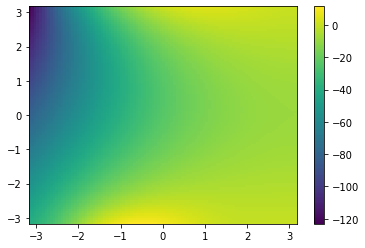

In [27]:
def exp_proj_steady(lam,n,delt,total_t):

    #Make mesh
    #lam=0.05
    #n=10
    x,y,X,Y,delx = make_domain(n)
    #delt=0.0001
    #total_t=10

    #Functions and definitions used 
    #lam=0.05
    #Function in the RHS: Zero for the given case
    def f_gh(t):
        return 0
    
    #Apply Boundary condition with ghost nodes
    def applyBC_man_New_gh(u,t):
        u[0,:]=np.append((1-np.exp(-lam*t))*gb(X[0,:]),0) #y= bot
        u[-1,:]=np.append((1-np.exp(-lam*t))*fb(X[-1,:]),0) #y=top
        u[:,0]= (1-np.exp(-lam*t))*(gb(ax)+(Y[:,0]-ay)/(by-ay)*(fb(ax)-gb(ax))) #x=bot
        #The following BC is 2nd order
        u[:,-1]= u[:,-3]+2*delx*0
        return u #x=top

    #initialize solution
    u=np.zeros_like(X)
    #Insert ghost cells
    u=np.column_stack((u,np.zeros_like(y)))
    t=0
    
    #Vector to calculate convergence
    u_ave=np.array([])
    u_ave=np.append(u_ave,1)
    
    #March in time
    while(np.abs(total_t-t)>1e-5):
        u=applyBC_man_New_gh(u,t)
        u=explicit(u,f_gh(t),delt,delx)
        t=t+delt
        u_ave=np.append(u_ave,np.average(np.abs(u)))
        #Check and break if convergence is achieved
        if (np.abs(u_ave[-2]-u_ave[-1])<1e-5):
            break
        #print('time=',t,'Norm 1=',np.abs(u_ave[-2]-u_ave[-1]))
    u= u[:,:-1]
      
    #Plot numerical solution
    plt.pcolor(X,Y,u)
    plt.colorbar()
    plt.show()

    #return solution matrix
    return #u

exp_proj_steady(0.05,100,0.001,1000)
